# Project Extension: User Movement in Location-Based Social Networks in Megalopolises

In this project extension, we are going to be focusing on the dataset containing location-based social networks of two densely populated cities: New York City and Tokyo.  Will be trying to answer similar questions as those explored in the article "Friendship and Mobility: User Movement in Location-Based Social Network".

Here is the pipeline which was undertaken during our data exploration:
1. Loading and Pre-processing the data --> OK
2. Identifying User's Homes: A Change of Scale --> OK
3. Distribution of User's Check-ins as a function of distance traveled: Do users restrict themselves to their neighborhoods, or do travel further away ? --> OK
4. Is there a clear work/home routine? What are these New Yorker's and Tokyoite's habits?
5. What type of activities are the most popular, when and where are they done? Are different types of venues geographically close or spread out?
6. Are these trends comparable between megalopolises?

Link to dataset: https://sites.google.com/site/yangdingqi/home/foursquare-dataset

In order to have a reference for interpretation (naming boroughs and hallamarks), here are two maps of New York City and Tokyo

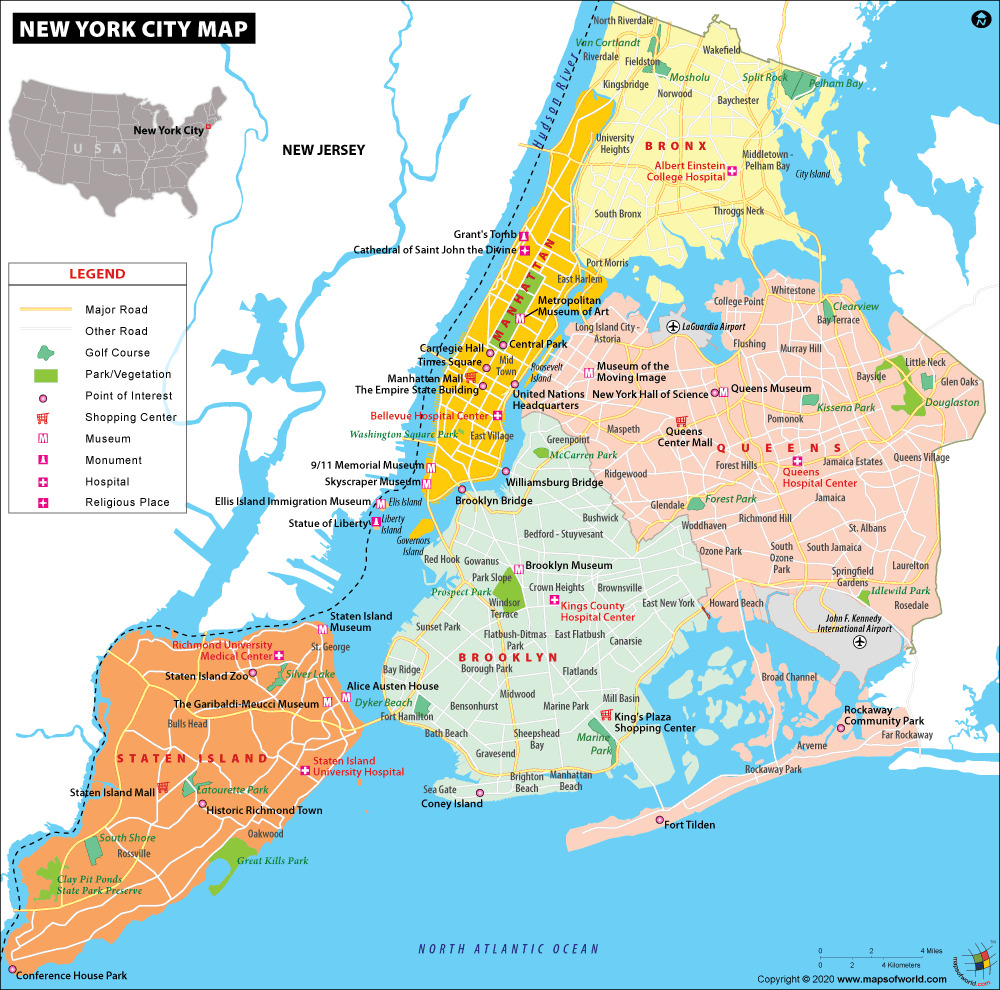

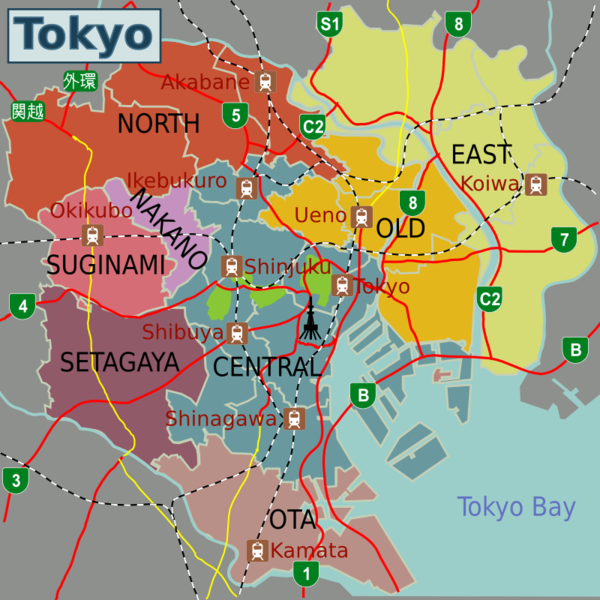

###### Importing the libraries needed for this project:

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

import folium  # INSTALL FOLIUM
from folium import plugins
import branca.colormap # In order to use heatmaps on folium maps
from collections import defaultdict # Also used when creating coloar bar

# Part 1: Loading and Pre-processing the Data

### <ins>Step 1</ins>: Loading the data

In [2]:
# Path
DATA_FOLDER = '/Users/louiseplacidet/Desktop/ADA/Project/Extension/Data/'
#DATA_FOLDER = './Data/'
NYC = DATA_FOLDER+'dataset_TSMC2014_NYC.txt'
TKY = DATA_FOLDER+'dataset_TSMC2014_TKY.txt'

# Loading data
nyc = pd.read_csv(NYC, header = None, sep='\t', engine='python',
                  names=['user_ID', 'venue_ID', 'venue_category_ID','venue_category_name',
                         'latitude', 'longitude', 'offset', 'UTC_time'])
tky = pd.read_csv(TKY, header = None, sep='\t', engine='python',
                  names=['user_ID', 'venue_ID', 'venue_category_ID','venue_category_name',
                         'latitude', 'longitude', 'offset', 'UTC_time'])

In [3]:
display(nyc.head(3))
display(tky.head(3))

user_ID                  venue_ID         venue_category_ID  \
0      470  49bbd6c0f964a520f4531fe3  4bf58dd8d48988d127951735   
1      979  4a43c0aef964a520c6a61fe3  4bf58dd8d48988d1df941735   
2       69  4c5cc7b485a1e21e00d35711  4bf58dd8d48988d103941735   

   venue_category_name   latitude  longitude  offset  \
0  Arts & Crafts Store  40.719810 -74.002581    -240   
1               Bridge  40.606800 -74.044170    -240   
2       Home (private)  40.716162 -73.883070    -240   

                         UTC_time  
0  Tue Apr 03 18:00:09 +0000 2012  
1  Tue Apr 03 18:00:25 +0000 2012  
2  Tue Apr 03 18:02:24 +0000 2012

user_ID                  venue_ID         venue_category_ID  \
0     1541  4f0fd5a8e4b03856eeb6c8cb  4bf58dd8d48988d10c951735   
1      868  4b7b884ff964a5207d662fe3  4bf58dd8d48988d1d1941735   
2      114  4c16fdda96040f477cc473a5  4d954b0ea243a5684a65b473   

     venue_category_name   latitude   longitude  offset  \
0         Cosmetics Shop  35.705101  139.619590     540   
1  Ramen /  Noodle House  35.715581  139.800317     540   
2      Convenience Store  35.714542  139.480065     540   

                         UTC_time  
0  Tue Apr 03 18:17:18 +0000 2012  
1  Tue Apr 03 18:22:04 +0000 2012  
2  Tue Apr 03 19:12:07 +0000 2012

In the two dataframes above, we are given additional information compared the dataframe in the replication project. Namely, we are given the "venue_category_name", which will enable us to draw more information about the habits of these New Yorkers and Tokyoites.

### <ins>Step 2</ins>: Pre-Processing the Data

###  1. Converting longitude and latitude into km values, and creating a grid

Similar to the Friendship and Mobility paper, we are estimating the home location of a user based on their check-in locations. This is accomplished by dividing our two cities into a grid, of size N by N km. N is the length of one unit in the grid and can be considered to be a design parameter. Indeed, we cannot use 25 km as we had previously done in the replication paper, given that we are working with a much denser dataset.

This is done by using the following conversions:

Latitude 1°: 110.574 km  
Longtiude: 1°: 111.320*cos(latitude) km

In [4]:
# The grid cells are discrete so we are rounding to the closest cell

def lat2km(lat, N):
    # Convert a latitude value to a N km grid
    km = np.round((110.574*lat)/N)
    return km
    
def long2km(long, lat, N):
    # Convert a longitude value to a N km grid 
    km = np.round((110.320 * long * np.cos(np.deg2rad(lat)))/N)
    return km
                  

In [5]:
N = 0.5
nyc['x_grid'] = long2km(nyc.longitude, nyc.latitude, N)
nyc['y_grid'] = lat2km(nyc.latitude, N)

tky['x_grid'] = long2km(tky.longitude, tky.latitude, N)
tky['y_grid'] = lat2km(tky.latitude, N)

In [8]:
# Calculate distance between two pairs of long/lat coordinates. 
# Solution from: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


### 2 . Getting the Local Time:

The time in the dataframe is the UTC time.  In order to compare the time that the activities were done in either New York or Tokyo, we need to convert the times into local times

In [9]:
def format_datetime(dt_series):

    def get_split_date(strdt):
        split_date = strdt.split()
        str_date = split_date[1] + ' ' + split_date[2] + ' ' + split_date[5] + ' ' + split_date[3]
        return str_date

    dt_series = pd.to_datetime(dt_series.apply(lambda x: get_split_date(x)), format = '%b %d %Y %H:%M:%S')

    return dt_series

In [10]:
nyc.UTC_time = format_datetime(nyc.UTC_time)
tky.UTC_time = format_datetime(tky.UTC_time)

In [11]:
nyc['local_time'] = nyc.apply(lambda x: x.UTC_time + dt.timedelta(minutes = x.offset), axis=1)
tky['local_time'] = tky.apply(lambda x: x.UTC_time + dt.timedelta(minutes = x.offset), axis=1)

In [12]:
nyc.head()

user_ID                  venue_ID         venue_category_ID  \
0      470  49bbd6c0f964a520f4531fe3  4bf58dd8d48988d127951735   
1      979  4a43c0aef964a520c6a61fe3  4bf58dd8d48988d1df941735   
2       69  4c5cc7b485a1e21e00d35711  4bf58dd8d48988d103941735   
3      395  4bc7086715a7ef3bef9878da  4bf58dd8d48988d104941735   
4       87  4cf2c5321d18a143951b5cec  4bf58dd8d48988d1cb941735   

   venue_category_name   latitude  longitude  offset            UTC_time  \
0  Arts & Crafts Store  40.719810 -74.002581    -240 2012-04-03 18:00:09   
1               Bridge  40.606800 -74.044170    -240 2012-04-03 18:00:25   
2       Home (private)  40.716162 -73.883070    -240 2012-04-03 18:02:24   
3       Medical Center  40.745164 -73.982519    -240 2012-04-03 18:02:41   
4           Food Truck  40.740104 -73.989658    -240 2012-04-03 18:03:00   

    x_grid  y_grid          local_time  
0 -12375.0  9005.0 2012-04-03 14:00:09  
1 -12403.0  8980.0 2012-04-03 14:00:25  
2 -12356.0  9004.0 2012-04-03 14:02:24  
3 -12367.0  9011.0 2012-04-03 14:02:41  
4 -12369.0  9010.0 2012-04-03 14:03:00

# Part 2: Identifying User's Homes: A Change of Scale

### <ins>Step 1</ins>: Identifying User's home using FourSquare Data and by inferring

In the FourSquare Data, some of the check-ins are labeled as the user's home.  However, not all users have check-ins corresponding to their homes (for instance, it is not the case for user 1).  As a result, the method used in the replication paper will also be applied to estimate the home locations for users who do not have check-ins labeled as "Home (private)".

Moreover, for the users who do have such check-ins, it is interesting to compare the coordinates of that check-in to the approximation we can make using the method described in the replication paper.  This will enable us to get a feel for the accuracy of our computation!

###### 1. The User's Homes According to FourSquare :

As stated above, some of the users don't have check-ins corresponding to their homes, as it is the case for user 1:

In [21]:
nyc[(nyc["user_ID"]==1)&(nyc["venue_category_name"]=="Home (private)")]

Empty DataFrame
Columns: [user_ID, venue_ID, venue_category_ID, venue_category_name, latitude, longitude, offset, UTC_time, x_grid, y_grid, local_time, cord]
Index: []

Moreover, in the table below, we can see that the users who do have check-ins corresponding to their homes, can have more than one check-in.  When comparing their latitude and longitude, they are quite close, and the home location assigned to the user will therefore be considered as the average of those.

In [22]:
# Retrieving all the homes check-ins
four_square_nyc_homes = nyc[nyc['venue_category_name'] == "Home (private)"][["user_ID", "venue_category_name", "latitude", "longitude"]] # Creating a dataframe with the home locations for the users
four_square_nyc_homes.set_index(["user_ID"], drop=True, inplace=True)
four_square_nyc_homes.sort_index(axis = 0, inplace = True) #Sorting this dataframe enables us to realize that some users have multiple check-ins related to their homes
display(four_square_nyc_homes.head(3))

four_square_tky_homes = tky[tky['venue_category_name'] == "Home (private)"][["user_ID", "venue_category_name", "latitude", "longitude"]] # Creating a dataframe with the home locations for the users
four_square_tky_homes.set_index(["user_ID"], drop=True, inplace=True)
four_square_tky_homes.sort_index(axis = 0, inplace = True) #Sorting this dataframe enables us to realize that some users have multiple check-ins related to their homes
display(four_square_tky_homes.head(3))

venue_category_name   latitude  longitude
user_ID                                          
2            Home (private)  40.625787 -74.153356
2            Home (private)  40.562843 -73.918346
2            Home (private)  40.625784 -74.082884

venue_category_name   latitude   longitude
user_ID                                           
21           Home (private)  35.705644  139.849608
21           Home (private)  35.705644  139.849608
21           Home (private)  35.705644  139.849608

In [23]:
# Taking the average if there are several ones for each user

four_square_nyc_homes = four_square_nyc_homes.groupby(by="user_ID")[["latitude","longitude"]].mean()
display(four_square_nyc_homes.head(3))

four_square_tky_homes = four_square_tky_homes.groupby(by="user_ID")[["latitude","longitude"]].mean()
display(four_square_tky_homes.head(3))

latitude  longitude
user_ID                      
2        40.594314 -74.018233
5        40.728001 -74.035888
6        40.833165 -73.941860

latitude   longitude
user_ID                       
21       35.705644  139.849608
42       35.584788  139.594220
63       35.668599  139.772672

###### 2. The User's Homes According to the replication paper's approximation technique :

Using the technique described in the replication paper, we consider that the dataframes for the homes have the x and y coordinates for the cell within the grid with the most check-ins.  We then estimate the home position by using the average longitude and latitude for check-ins within this cell for each user.

To accomplish this, we concatenate the x and y coordinates for the grid into a string and then using the mode on that string. This ensures that the mode is being found on a given x-y coordinate pair.

In [41]:
# Concatenate the coordinates into a string to use as the mode
nyc['cord'] = nyc.x_grid.astype(str) + nyc.y_grid.astype(str)
tky['cord'] = tky.x_grid.astype(str) + tky.y_grid.astype(str)

In [42]:
# # The home locations can be obtained by counting the most common x and y cells for each user
# # This is done by storing the mode of each user's check-in cell's x and y coordinates.
nyc_homes = pd.DataFrame()
nyc_homes['mode_cord'] = nyc.groupby(['user_ID'])['cord'].apply(pd.Series.mode)
nyc_homes = nyc_homes.reset_index().drop(['level_1'], axis=1) # get rid of multiindex

tky_homes = pd.DataFrame()
tky_homes['mode_cord'] = tky.groupby(['user_ID'])['cord'].apply(pd.Series.mode)
tky_homes = tky_homes.reset_index().drop(['level_1'], axis=1)

The dataframes for the homes have the x and y coordinates for the cell within the grid with the most check-ins. We estimate the home position by using the average longitude and latitude for check-ins within this cell for each user. 

In [43]:
# Combine the dataframes by merging on multiple columns; this keeps only the check ins in the 'home' cell. 
nyc_homes = pd.merge(nyc_homes, nyc, how = 'left', left_on=['user_ID', 'mode_cord'], right_on =['user_ID', 'cord'])

# Obtain the mean longitude and latitude for the estimated home location
nyc_homes = nyc_homes.groupby('user_ID')[['longitude', 'latitude']].mean()

tky_homes = pd.merge(tky_homes, tky, how = 'left', left_on=['user_ID', 'mode_cord'], right_on =['user_ID', 'cord'])
tky_homes = tky_homes.groupby('user_ID')[['longitude', 'latitude']].mean()

In [44]:
display(nyc_homes.head(3))
display(tky_homes.head(3))

longitude   latitude
user_ID                      
1       -74.004165  40.719994
2       -73.913707  40.646648
3       -73.988551  40.745732

longitude   latitude
user_ID                       
1        139.773418  35.698775
2        139.698197  35.658062
3        139.600839  35.668477

###### 3. Checking Out the Accuracy of our Predictions :

Now that we have an approximation of all the user's homes using the approximation technique of the article, let's see if this estimation is close to the home check-ins provided by the FourSquare. If that is the case, than we can associate to the users who don't have FourSquare home check-ins our approximation with a correct accuracy.

In [45]:
comparing_homes_nyc = pd.merge(four_square_nyc_homes, nyc_homes, how='left', left_on=['user_ID'], right_on=['user_ID'],suffixes=["_foursquare","_approx"])
comparing_homes_nyc['latitude_accuracy'] = (comparing_homes_nyc['latitude_foursquare'] - comparing_homes_nyc['latitude_approx'])/comparing_homes_nyc['latitude_foursquare']
comparing_homes_nyc['longitude_accuracy'] = (comparing_homes_nyc['longitude_foursquare'] - comparing_homes_nyc['longitude_approx'])/comparing_homes_nyc['longitude_foursquare']
display(comparing_homes_nyc.sample(3))


comparing_homes_tky = pd.merge(four_square_tky_homes, tky_homes, how='left', left_on=['user_ID'], right_on=['user_ID'],suffixes=["_foursquare","_approx"])
comparing_homes_tky['latitude_accuracy'] = (comparing_homes_tky['latitude_foursquare'] - comparing_homes_tky['latitude_approx'])/comparing_homes_tky['latitude_foursquare']
comparing_homes_tky['longitude_accuracy'] = (comparing_homes_tky['longitude_foursquare'] - comparing_homes_tky['longitude_approx'])/comparing_homes_tky['longitude_foursquare']
display(comparing_homes_tky.sample(3))


latitude_foursquare  longitude_foursquare  longitude_approx  \
user_ID                                                                
770                40.877199            -73.836025        -73.836625   
180                40.783960            -74.012385        -73.997599   
281                40.784317            -74.134901        -74.152748   

         latitude_approx  latitude_accuracy  longitude_accuracy  
user_ID                                                          
770            40.877584          -0.000009           -0.000008  
180            40.924009          -0.003434            0.000200  
281            40.747106           0.000912           -0.000241

latitude_foursquare  longitude_foursquare  longitude_approx  \
user_ID                                                                
2190               35.576574            139.573836        139.572871   
1169               35.700848            139.563647        139.570506   
1469               35.732010            139.482199        139.513233   

         latitude_approx  latitude_accuracy  longitude_accuracy  
user_ID                                                          
2190           35.579449          -0.000081            0.000007  
1169           35.696124           0.000132           -0.000049  
1469           35.726130           0.000165           -0.000222

From the values in the dataframe above, the accuracy is considerably small, thus confirming that the prediction method provides accurate results.  We can then infer the user's homes for those who don't have a check-in "Home (private)".

###### 4. Computing the final DataFrame containing the user's homes:

To construct the DataFrame containing the user's homes, we will use the home locations from FourSquare if they are provided.  In the absence of home check-ins, we will approximate as done in the replication paper:

In [46]:
# Merging the dataframe so that all users are present, and we associated to them their coordinates provided by foursquare (nan if there are none), and the approximated ones
final_nyc_homes = pd.merge(four_square_nyc_homes, nyc_homes, how='right', left_on=['user_ID'], right_on=['user_ID'], suffixes=['_foursquare','_approx'])

#Setting the coordinates to the foursquare values if they are provided, else tot the infered values
final_nyc_homes['latitude'] = np.where(np.isnan(final_nyc_homes['latitude_foursquare']), final_nyc_homes['latitude_approx'], final_nyc_homes['latitude_foursquare'])
final_nyc_homes['longitude'] = np.where(np.isnan(final_nyc_homes['longitude_foursquare']), final_nyc_homes['longitude_approx'], final_nyc_homes['longitude_foursquare'])
nyc_homes = final_nyc_homes # Renaming into the final dataframe that will be used from now on

# The same is done for Tokyo:
final_tky_homes = pd.merge(four_square_tky_homes, tky_homes, how='right', left_on=['user_ID'], right_on=['user_ID'], suffixes=['_foursquare','_approx'])
final_tky_homes['latitude'] = np.where(np.isnan(final_tky_homes['latitude_foursquare']), final_tky_homes['latitude_approx'], final_tky_homes['latitude_foursquare'])
final_tky_homes['longitude'] = np.where(np.isnan(final_tky_homes['longitude_foursquare']), final_tky_homes['longitude_approx'], final_tky_homes['longitude_foursquare'])
tky_homes = final_tky_homes # Renaming into the final dataframe that will be used from now on


# Renaming columns
nyc_homes = nyc_homes.add_suffix('_home')
tky_homes = tky_homes.add_suffix('_home')

print('For NYC: ')
display(nyc_homes.head(4))
print('For Tokyo: ')
display(tky_homes.head(4))

For NYC: 


latitude_foursquare_home  longitude_foursquare_home  \
user_ID                                                        
1                             NaN                        NaN   
2                       40.594314                 -74.018233   
3                             NaN                        NaN   
4                             NaN                        NaN   

         longitude_approx_home  latitude_approx_home  latitude_home  \
user_ID                                                               
1                   -74.004165             40.719994      40.719994   
2                   -73.913707             40.646648      40.594314   
3                   -73.988551             40.745732      40.745732   
4                   -73.941512             40.816883      40.816883   

         longitude_home  
user_ID                  
1            -74.004165  
2            -74.018233  
3            -73.988551  
4            -73.941512

For Tokyo: 


latitude_foursquare_home  longitude_foursquare_home  \
user_ID                                                        
1                             NaN                        NaN   
2                             NaN                        NaN   
3                             NaN                        NaN   
4                             NaN                        NaN   

         longitude_approx_home  latitude_approx_home  latitude_home  \
user_ID                                                               
1                   139.773418             35.698775      35.698775   
2                   139.698197             35.658062      35.658062   
3                   139.600839             35.668477      35.668477   
4                   139.759940             35.665565      35.665565   

         longitude_home  
user_ID                  
1            139.773418  
2            139.698197  
3            139.600839  
4            139.759940

In [48]:
# Dropping the columns in order to only keep final home coordinates

nyc_homes.drop(['latitude_foursquare_home', 'longitude_foursquare_home', 'longitude_approx_home', 'latitude_approx_home'],axis = 1, inplace = True)
tky_homes.drop(['latitude_foursquare_home', 'longitude_foursquare_home', 'longitude_approx_home', 'latitude_approx_home'],axis = 1, inplace = True)

In [49]:
print("Final dataframe of NYC homes: ")
display(nyc_homes.head(5))
print("Final dataframe of Tokyo homes: ")
display(tky_homes.head(5))

Final dataframe of NYC homes: 


latitude_home  longitude_home
user_ID                               
1            40.719994      -74.004165
2            40.594314      -74.018233
3            40.745732      -73.988551
4            40.816883      -73.941512
5            40.728001      -74.035888

Final dataframe of Tokyo homes: 


latitude_home  longitude_home
user_ID                               
1            35.698775      139.773418
2            35.658062      139.698197
3            35.668477      139.600839
4            35.665565      139.759940
5            35.699554      139.770995

### <ins>Step 2</ins>: Locating User's homes, are they clustered?


Now that we have associated a home to each user, an interesting question is to see if the are residential areas in NYC and Tokyo.  Are the home clustered together and we can define specific areas? Or are user's homes spread out over the entirety of these dense cities?

###### 1. Getting the mean coordinates of all check-ins for both NYC and Tokyo

In order to plot where the residential areas are located on the heatmap provided by the folium library, we need to compute the average coordinates of all check-ins for both cities respectively.  As a result, we will plug in these mean coordinates and be able to display the map centered on the area we are interested in.

In [55]:
nyc_coordinates = [nyc.latitude.mean(), nyc.longitude.mean()]
tky_coordinates = [tky.latitude.mean(), tky.longitude.mean()]

###### 2. Plotting where the user's homes are located:

Now let's plot the density of user's homes for both New York city and Tokyo:

In [95]:
# In order to insert a color bar, the following stack overflow was used: https://stackoverflow.com/questions/47163728/how-to-add-legend-gradient-in-folium-heat-map

map_nyc = folium.Map(llocation=nyc_coordinates, zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
heatmap_locs = nyc_homes[['latitude_home', 'longitude_home']].to_numpy()

steps=50
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(map_nyc) #add color bar at the top of the map

# # plot heatmap
map_nyc.add_child(plugins.HeatMap(heatmap_locs, gradient = gradient_map, radius=10))
print("Heatmap of User's Homes for NYC:")
map_nyc

Heatmap of User's Homes for NYC:


In [96]:
map_tky = folium.Map(tky_coordinates, zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
heatmap_locs = tky_homes[['latitude_home', 'longitude_home']].to_numpy()

steps=50
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(map_tky) #add color bar at the top of the map

# # plot heatmap
map_tky.add_child(plugins.HeatMap(heatmap_locs, gradient = gradient_map, radius=10))
print("Heatmap of User's Homes in Tokyo:")
map_tky

Heatmap of User's Homes in Tokyo:


When looking at the New York heat map, it appears that the user's homes are more evenly distributed over Manhattan, with some users located also in Brooklyn.

In the case of Tokyo, the user's homes are also spread out, with some areas of higher concentration (the "North", Nakano and Suginami, and the "Old" regions).

As a result, we can see in both cases that in densely populated are the residential areas are spread out over the entire cities and not restricted to a certain region.

# Part 3: Distribution of User's Check-ins as a function of distance traveled

Now that we have associated a home to each of the user of this platform, the next interesting step consists in looking at the fraction of check-ins as a function of the distance.

Indeed, we can compare this distribution to the one presented in the replication article (showing a kink at 100 km).  A current hypothesis is that the distribution in cities would be more spread out: given that a city tends to be attractive for its out of habit experience, one could expect that users travel farther from them home to discover new places. Let's see if this hypothesis holds up!

### <ins>Step 1</ins>: Computing distance of check-ins from user's homes

Let's compute the distance of the user's home locations to that of their check-ins

###### 1. Merging homes locations with dataframe containing all of the checkins 

In [99]:
nyc_checkin_homes = nyc.merge(nyc_homes[['latitude_home','longitude_home']], left_on='user_ID', right_index=True)
tky_checkin_homes = tky.merge(tky_homes[['latitude_home','longitude_home']], left_on='user_ID', right_index=True)

display(nyc_checkin_homes.head())
print(nyc.shape, nyc_homes.shape, nyc_checkin_homes.shape)

user_ID                  venue_ID         venue_category_ID  \
0        470  49bbd6c0f964a520f4531fe3  4bf58dd8d48988d127951735   
626      470  4e08ad8cd4c03ae0b9d11f93  4bf58dd8d48988d1d2941735   
650      470  4be09b7fcb81c9b62069668b  4bf58dd8d48988d1d2941735   
652      470  49f50c9ff964a5208a6b1fe3  4bf58dd8d48988d1d2941735   
654      470  4a6a09b1f964a52071cc1fe3  4bf58dd8d48988d1d2941735   

     venue_category_name   latitude  longitude  offset            UTC_time  \
0    Arts & Crafts Store  40.719810 -74.002581    -240 2012-04-03 18:00:09   
626     Sushi Restaurant  40.683178 -73.965746    -240 2012-04-03 23:36:34   
650     Sushi Restaurant  40.624513 -73.965070    -240 2012-04-03 23:46:46   
652     Sushi Restaurant  40.677611 -73.963748    -240 2012-04-03 23:47:16   
654     Sushi Restaurant  40.702752 -73.990696    -240 2012-04-03 23:47:49   

      x_grid  y_grid          local_time            cord  latitude_home  \
0   -12375.0  9005.0 2012-04-03 14:00:09  -12375.09005.0       40.71981   
626 -12376.0  8997.0 2012-04-03 19:36:34  -12376.08997.0       40.71981   
650 -12386.0  8984.0 2012-04-03 19:46:46  -12386.08984.0       40.71981   
652 -12376.0  8996.0 2012-04-03 19:47:16  -12376.08996.0       40.71981   
654 -12376.0  9001.0 2012-04-03 19:47:49  -12376.09001.0       40.71981   

     longitude_home  
0        -74.002581  
626      -74.002581  
650      -74.002581  
652      -74.002581  
654      -74.002581

(227428, 12) (1083, 2) (227428, 14)


###### 2. Calculating distance traveled from home

In [100]:
# Calculating distance traveled from home, using haversine function (see above for its definition)
nyc_checkin_homes['distance'] = haversine_np(nyc_checkin_homes['longitude'], nyc_checkin_homes['latitude'], 
                                      nyc_checkin_homes['longitude_home'], nyc_checkin_homes['latitude_home'])

tky_checkin_homes['distance'] = haversine_np(tky_checkin_homes['longitude'], tky_checkin_homes['latitude'], 
                                      tky_checkin_homes['longitude_home'], tky_checkin_homes['latitude_home'])

### <ins>Step 2</ins>: Plotting the Fraction of Check-ins as a function of distance traveled from home

###### 1. Plotting the distribution

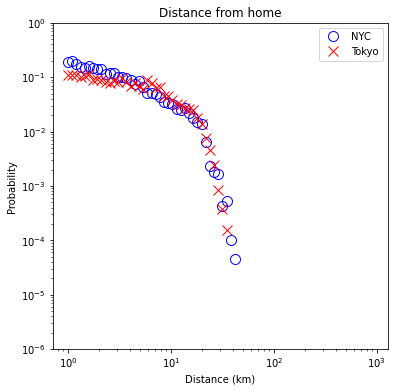

In [102]:
hist_nyc, bin_edges_nyc = np.histogram(nyc_checkin_homes['distance'], bins=np.logspace(np.log10(1),np.log10(1000.0), 75), density=True)
hist_tky, bin_edges_tky = np.histogram(tky_checkin_homes['distance'], bins=np.logspace(np.log10(1),np.log10(1000.0), 75), density=True)


plt.figure(figsize=(6,6))
plt.plot(bin_edges_nyc[:-1], hist_nyc, 'bo', bin_edges_tky[:-1], hist_tky, 'rx', mfc='none', ms=10)
plt.xscale('log')
plt.yscale('log')
plt.legend(['NYC', 'Tokyo'])
plt.title('Distance from home')
plt.xlabel('Distance (km)')
plt.ylabel('Probability')
plt.ylim([1e-6,1e0])
plt.show()

###### 3. Interpretation: comparing this distribution to that on a global scale

From the plot above, we can first notice that the probability density distribution is very similar between New York City and Tokyo, conveying that a common "city behavior".

Compared to the replication paper figure (inserted below), users living in megalopolises tend to only travel up to 100 km.  On the other hand, in "Friendship and Mobility", users travel distances up to 10,000 km from their homes.

As a result, New Yorkers and Tokyoites travel considerably smaller distances than the observations made on a larger scale.  However, what are the habits of these New Yorkers and Tokyoites within this 100 km?

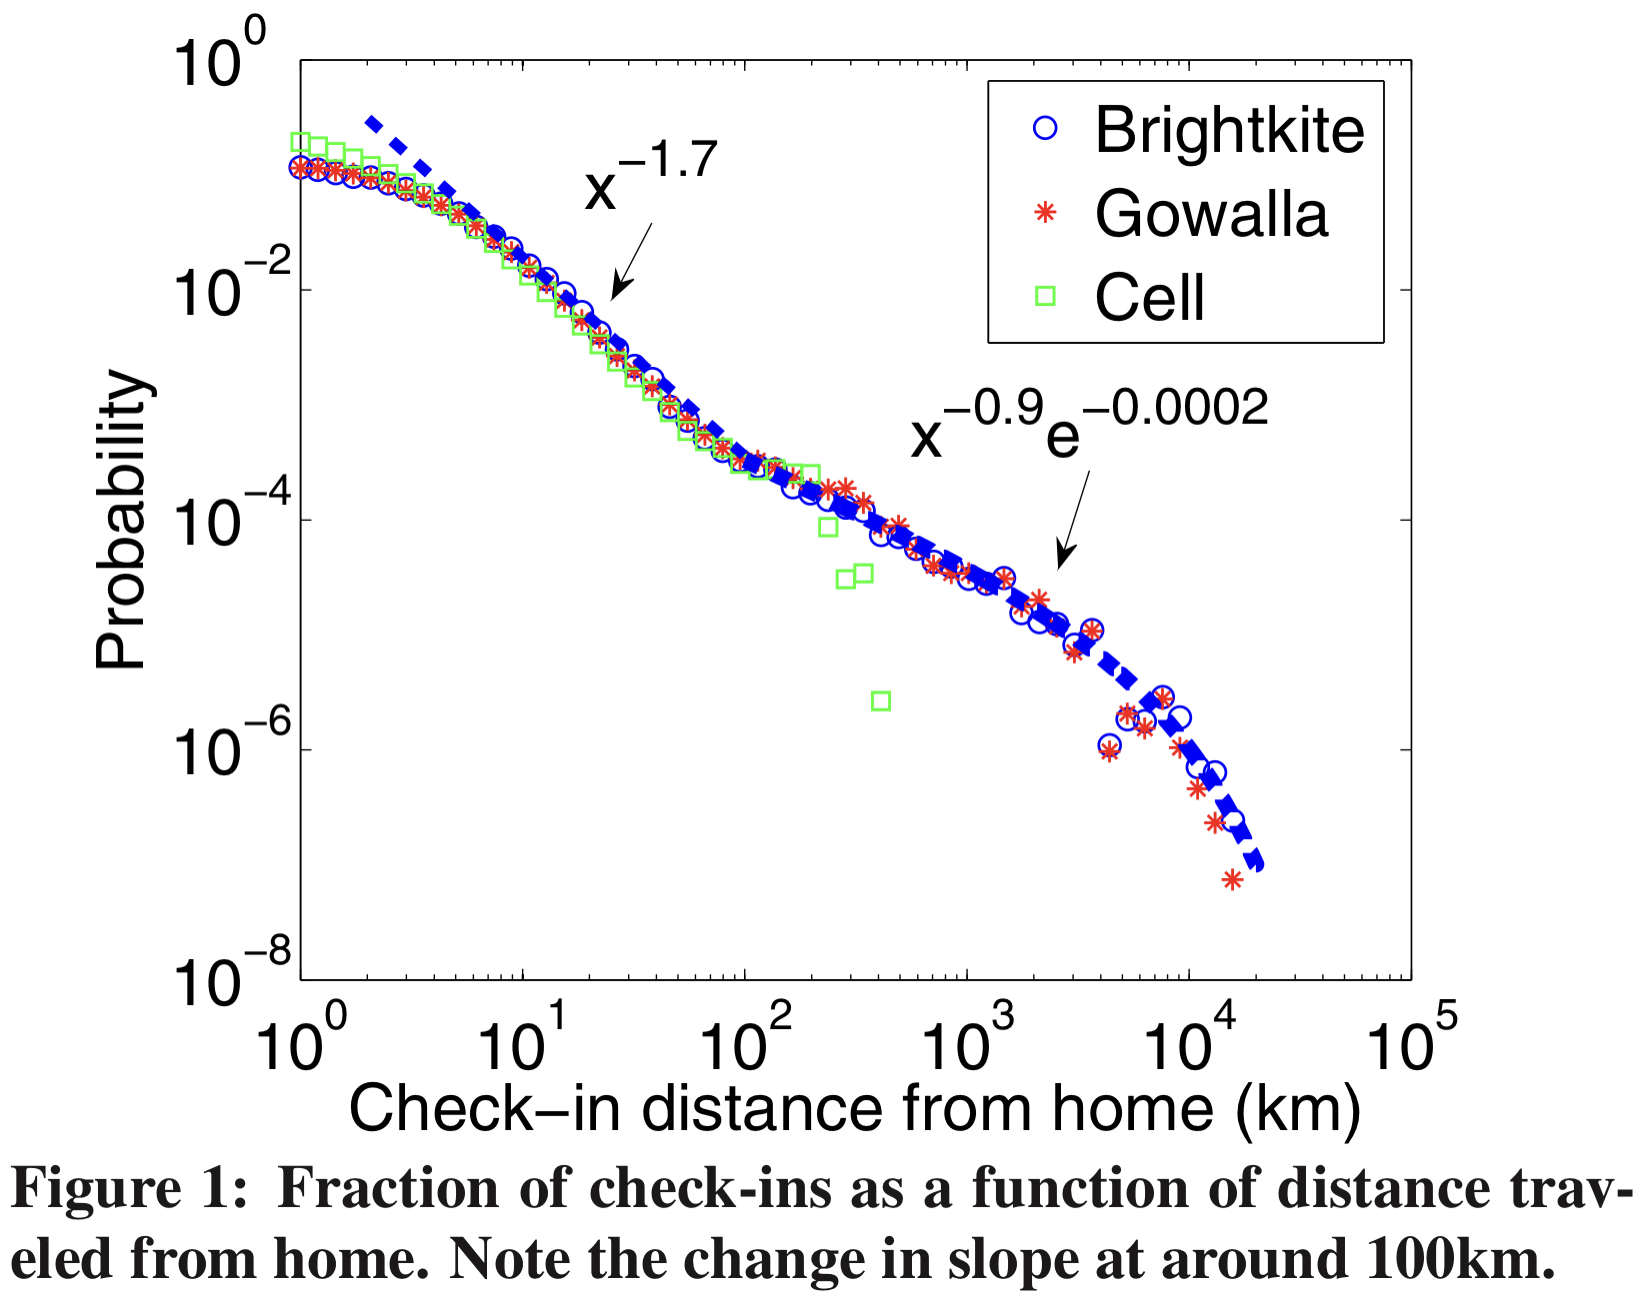

# Plotting the map

https://ngmdb.usgs.gov/topoview/viewer/#12/40.6875/-73.9375

https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391


Text(0, 0.5, 'latitude')

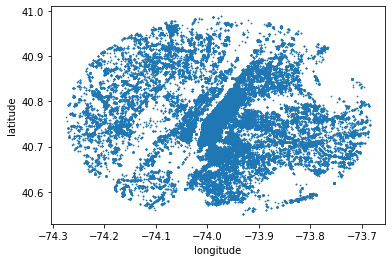

In [24]:
plt.scatter(nyc_checkin_homes['longitude'], nyc_checkin_homes['latitude'], s= 0.5)
plt.xlabel('longitude')
plt.ylabel('latitude')

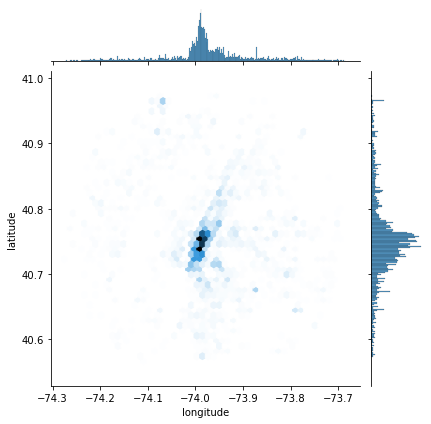

In [25]:
sns.jointplot(data = nyc_checkin_homes, x = 'longitude', y = 'latitude', kind="hex")

In [26]:
# import libraries

#INSTALL GEOPANDAS AND DESCARTES

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

In [27]:
# import street map
nyc_street_map = gpd.read_file('./nyc/geo_export_f26fc85a-8456-4e4a-887c-06898ab0ae9f.shp')
tky_street_map = gpd.read_file('./tky/japan_administrative.shp')

In [28]:
## Create geopandas dataframe

# designate coordinate system
crs = {'init':'espc:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(nyc['longitude'], nyc['latitude'])]  # we are joining latitude and longitude
# create GeoPandas dataframe
nyc_geo_df = gpd.GeoDataFrame(nyc, crs = crs, geometry = geometry)  # crs is the coordinate reference system

geometry = [Point(xy) for xy in zip(tky['longitude'], tky['latitude'])]  # we are joining latitude and longitude
# create GeoPandas dataframe
tky_geo_df = gpd.GeoDataFrame(tky, crs = crs, geometry = geometry)  # crs is the coordinate reference system



In [45]:
nyc_geo_df.head(2)

user_ID                  venue_ID         venue_category_ID  \
0      470  49bbd6c0f964a520f4531fe3  4bf58dd8d48988d127951735   
1      979  4a43c0aef964a520c6a61fe3  4bf58dd8d48988d1df941735   

   venue_category_name  latitude  longitude  offset            UTC_time  \
0  Arts & Crafts Store  40.71981 -74.002581    -240 2012-04-03 18:00:09   
1               Bridge  40.60680 -74.044170    -240 2012-04-03 18:00:25   

    x_grid  y_grid          local_time                    geometry  
0 -12375.0  9005.0 2012-04-03 14:00:09  POINT (-74.00258 40.71981)  
1 -12403.0  8980.0 2012-04-03 14:00:25  POINT (-74.04417 40.60680)

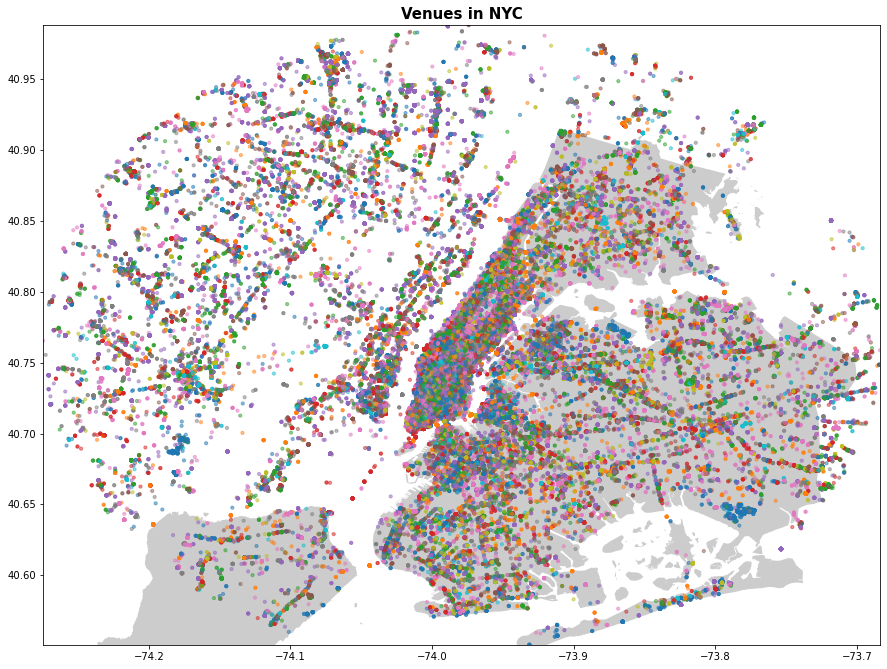

In [30]:
# Graph

fig, ax = plt.subplots(figsize=(15,15))
# add .shp mapfile to axes
nyc_street_map.plot(ax = ax, alpha=0.4, color='grey')
nyc_geo_df.plot(column='venue_category_name', ax=ax, alpha=0.5, legend=False, markersize=10)

plt.title('Venues in NYC', fontsize=15, fontweight='bold')
plt.xlim(min(nyc['longitude']), max(nyc['longitude']))
plt.ylim(min(nyc['latitude']), max(nyc['latitude']))
plt.show()

# Part 4:

# Part 5: What type of activities are the most popular, when and where are they done?

### 1. Visualizing checkins in time

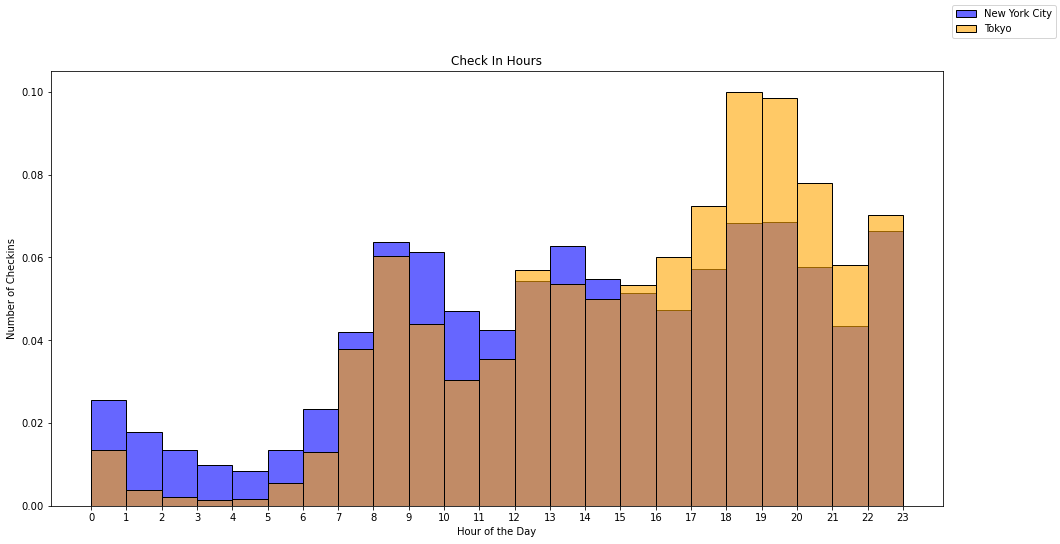

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
sns.histplot(data = nyc, x = nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
             stat = 'probability', label = 'New York City')
#sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6, label = 'Tokyo')
sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
             stat = 'probability', label = 'Tokyo')
fig.legend()
ax.set(title = 'Check In Hours', xlabel='Hour of the Day', ylabel ='Number of Checkins', xticks = np.arange(0,24));

# I decided to sample the tokyo data to normalize against the different size of the data sets
# Looking at the distribution of the data, we can see that NYC is more active in the early hours of the morning relative to Tokyo
# We can also see that people in Tokyo are more active in the early evening (5-9)

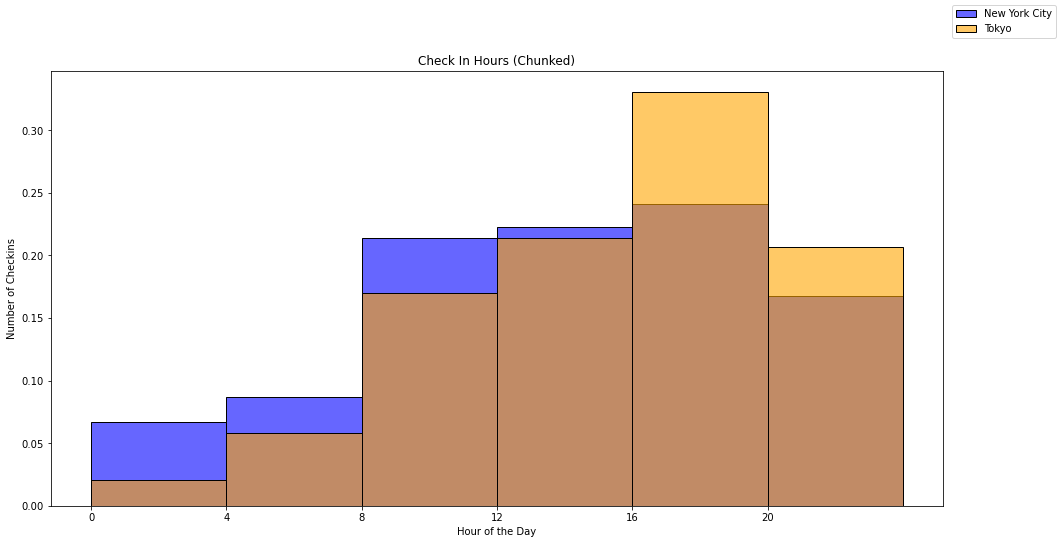

In [33]:
N = 4 # to group by hours

fig, ax = plt.subplots(figsize=(16,8))
sns.histplot(data = nyc, x = nyc.local_time.dt.hour, ax = ax, binwidth=N, color = 'blue', alpha = 0.6,
             stat = 'probability', label = 'New York City')
#sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6, label = 'Tokyo')
sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=N, color = 'orange', alpha = 0.6,
             stat = 'probability', label = 'Tokyo')
fig.legend()
ax.set(title = 'Check In Hours (Chunked)', xlabel='Hour of the Day', ylabel ='Number of Checkins', xticks = np.arange(0,24,N));

# I decided to sample the tokyo data to normalize against the different size of the data sets
# Looking at the distribution of the data, we can see that NYC is more active in the early hours of the morning relative to Tokyo
# We can also see that people in Tokyo are more active in the early evening (5-9)

### 2. Visualizing types of activities

[Text(0.5, 1.0, 'Tokyo activities')]

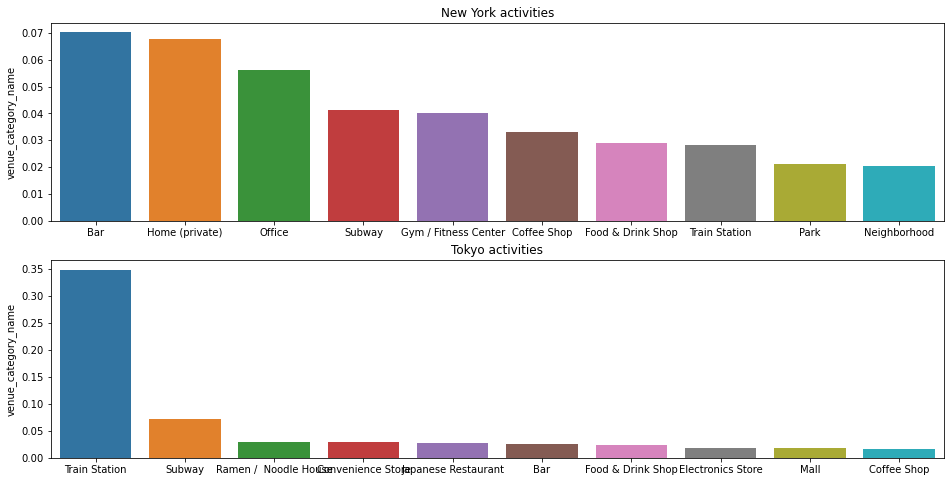

In [42]:
# What are the most popular types of venues?
nyc_pop_venues = nyc.venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.venue_category_name.value_counts().nlargest(10);

fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/len(nyc), ax = ax[0]).set(title='New York activities')
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/len(tky), ax=ax[1]).set(title='Tokyo activities')

### 3. Are there certain check in locations that are more popular at different times of the day?

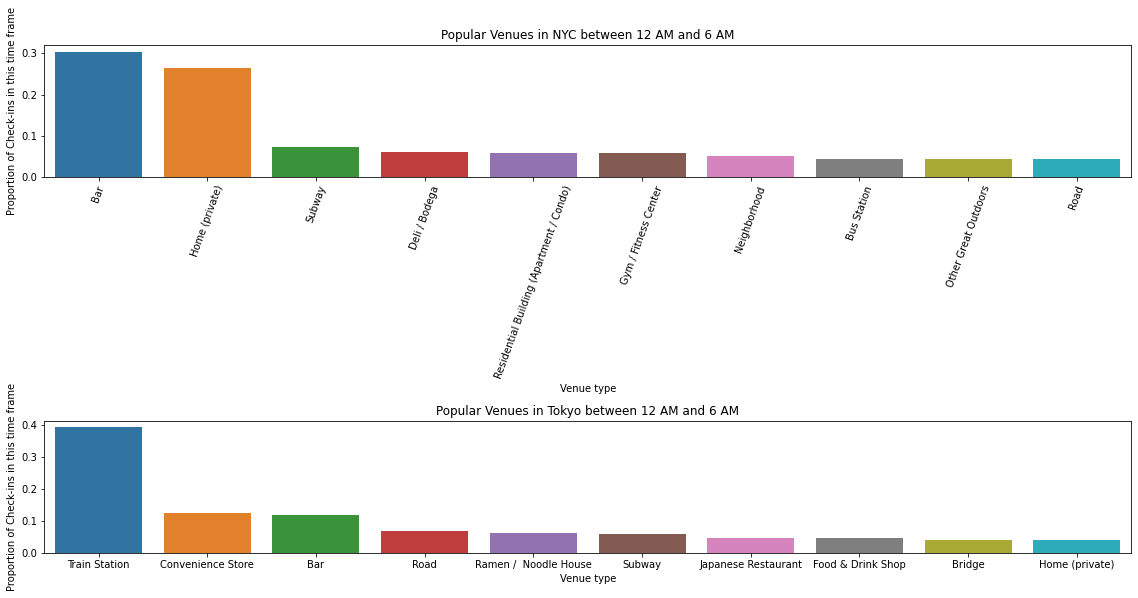

In [35]:
# Between midnight and 6 am
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(1,6))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(1,6))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between 12 AM and 6 AM',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 12 AM and 6 AM',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

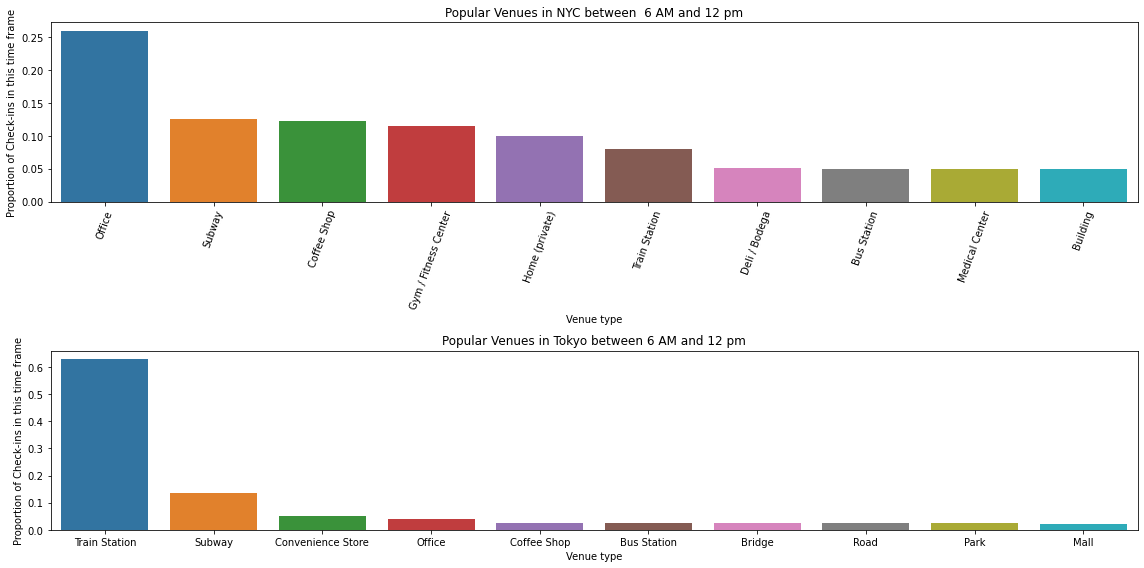

In [36]:
# Between 6 and 12 pm
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(6,12))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(6,12))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between  6 AM and 12 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 6 AM and 12 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

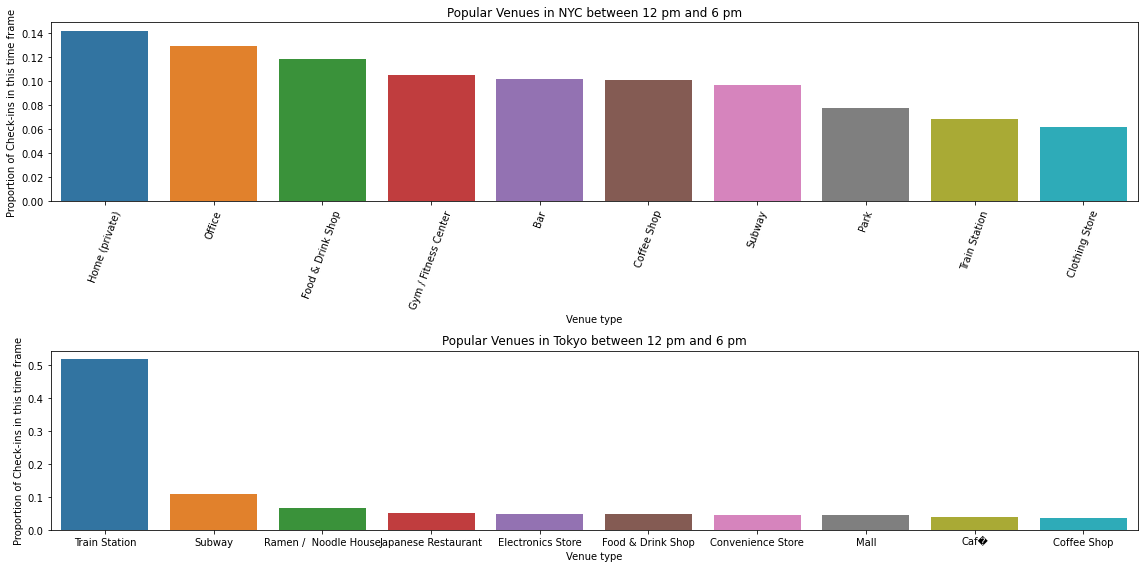

In [37]:
# Between 12 pm - 6 pm
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(12,18))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(12,18))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between 12 pm and 6 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 12 pm and 6 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

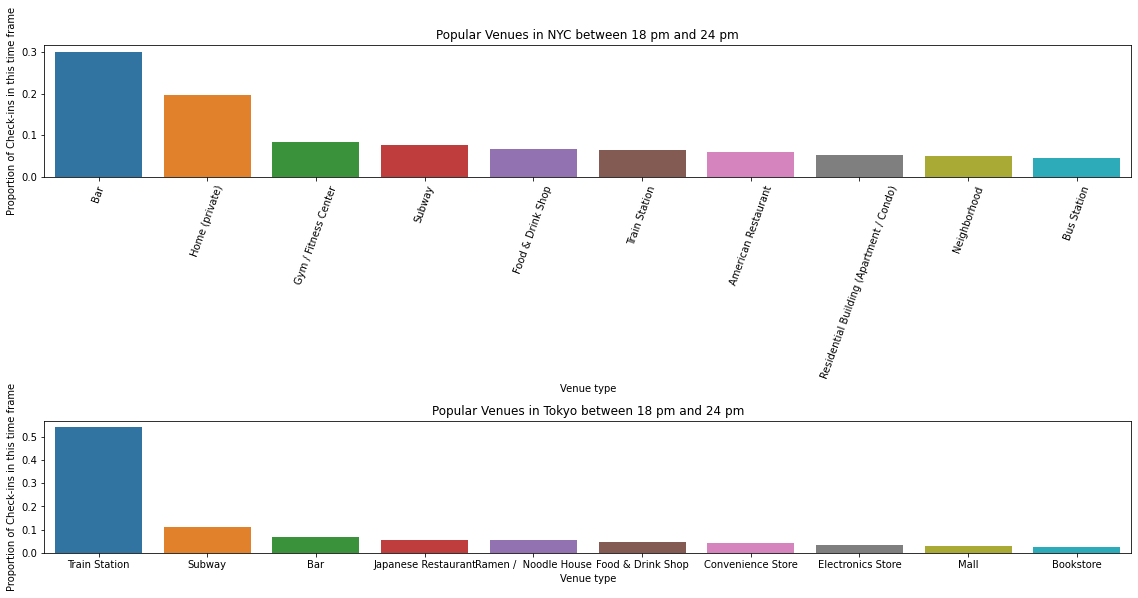

In [38]:
# Between 6 pm- midnight
nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(18,24))].venue_category_name.value_counts().nlargest(10);
tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(np.arange(18,24))].venue_category_name.value_counts().nlargest(10);



fig, ax = plt.subplots(2, figsize=(16,8))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/np.sum(nyc_pop_venues), ax = ax[0])
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/np.sum(tky_pop_venues), ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)

ax[0].set(title = 'Popular Venues in NYC between 18 pm and 24 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
ax[1].set(title = 'Popular Venues in Tokyo between 18 pm and 24 pm',
          xlabel = 'Venue type', ylabel = 'Proportion of Check-ins in this time frame')
plt.tight_layout()

Train stations in Tokyo...

In [50]:
nyc.longitude.mean()

-73.9745563288135

In [47]:
m = folium.Map([40.754, -73.974], zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
nyc.loc[nyc.local_time.dt.hour.isin(np.arange(1,6))][['latitude', 'longitude']]

heatmap_locs = nyc.loc[nyc.local_time.dt.hour.isin(np.arange(1,6))][['latitude', 'longitude']].to_numpy()

# # plot heatmap
m.add_child(plugins.HeatMap(heatmap_locs, radius=10))
m


In [51]:
tky.latitude.mean()

35.67637001425003

In [52]:
tky.longitude.mean()

139.71321412281134

In [54]:
m = folium.Map([35.676, 139.713], zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
tky.loc[tky.local_time.dt.hour.isin(np.arange(1,6))][['latitude', 'longitude']]

heatmap_locs = tky.loc[tky.local_time.dt.hour.isin(np.arange(1,6))][['latitude', 'longitude']].to_numpy()

# # plot heatmap
m.add_child(plugins.HeatMap(heatmap_locs, radius=10))
m
